In [2]:
import os
import json

In [11]:
def get_final_particles_from_record(record):
    final_step = record['history'][-1]
    particles = final_step['particles']
    if 'resample_indices' in final_step:
        particles = [
            {**particles[i], **{'weight': final_step['average_weight']}}
            for i in final_step['resample_indices']
        ]
    return particles

In [21]:
results_dir = 'results/Meta-Llama-3.1-8B-Instruct/character'

sis_path = os.path.join(results_dir, 'local', 'Meta-Llama-3.1-8B-Instruct-local-1-0.5-p10-character.jsonl')
sis_results = []
with open(sis_path, 'r') as f:
    for line in f:
        sis_results.append(json.loads(line))

sis_questions = [r['question'] for r in sis_results]

In [22]:
smc_path = os.path.join(results_dir, 'smc', 'Meta-Llama-3.1-8B-Instruct-smc-1-0.5-p10-character.jsonl')
smc_results = []
with open(smc_path, 'r') as f:
    for line in f:
        smc_results.append(json.loads(line))

question2results = {r['question'] : r for r in smc_results}

smc_results = []
for q in sis_questions:
    smc_results.append(question2results[q])

In [24]:
assert [r['question'] for r in sis_results] == [r['question'] for r in smc_results]

In [23]:
import numpy as np
def mean_log_weight(record):
    """ Estimates log Z - KL(q | p) """
    particles = get_final_particles_from_record(record)
    return np.mean([p['weight'] for p in particles])

def log_mean_weight(record):
    """ Estimates KL(p | q) - log Z """
    particles = get_final_particles_from_record(record)
    log_weights = [p['weight'] for p in particles]
    return np.log(np.mean(np.exp(log_weights)))

In [33]:
mean_log_weights = []
for i in range(len(sis_results)):
    # KL(q_smc | p) - KL(q_sis | p)
    mean_log_weights.append((
        i,
        sis_results[i]['question'], 
        mean_log_weight(sis_results[i]['record']) - mean_log_weight(smc_results[i]['record'])
    ))

In [34]:
mean_log_weights.sort(key=lambda x: x[2], reverse=False)

(array([  1.,   0.,   0.,   2.,   2.,   5.,   0.,   6.,   4.,  14.,  19.,
         36.,  62., 661., 174.,  29.,  11.,   5.,   1.,   2.]),
 array([-74.79856217, -69.39434484, -63.99012751, -58.58591019,
        -53.18169286, -47.77747553, -42.37325821, -36.96904088,
        -31.56482355, -26.16060622, -20.7563889 , -15.35217157,
         -9.94795424,  -4.54373692,   0.86048041,   6.26469774,
         11.66891506,  17.07313239,  22.47734972,  27.88156704,
         33.28578437]),
 <BarContainer object of 20 artists>)

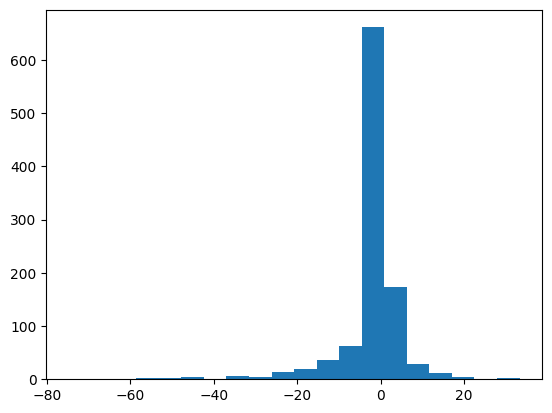

In [38]:
import matplotlib.pyplot as plt

plt.hist([x[2] for x in mean_log_weights], bins=20)

In [54]:
from bench.spider.evaluator import Evaluator
from pathlib import Path
from functools import lru_cache

spider_dir = Path('../spider/data/spider')

evaluator = Evaluator(spider_dir, timeout=10)

@lru_cache
def cached_eval(x, y, db):
    return evaluator.evaluate(x, y, db_name=db)

from genparse.experimental.batch_inference.steer import ParticleApproximation, Particle
from genparse import EOS

def create_particle_approx(particles):
    return ParticleApproximation(
        [
            Particle(
                prompt=None,
                context=p['context'],
                context_ids=p['context_ids'],
                done=True,
                log_weight=p['weight'],
                log_weight_updates=None,
                parent=None,
            )
            for p in particles
        ]
    )

def posterior_weighted_eval(results):
    eos = EOS
    particles = create_particle_approx(
        get_final_particles_from_record(results['record'])
    )
    gold = results['gold']
    db = results['db_name']

    weighted_acc = 0
    particle_results = {}
    for pred, p in particles.posterior.items():
        if np.isnan(p):
            p = 0
        pred = pred.rstrip(eos)
        acc = cached_eval(gold, pred, db)
        assert pred not in particle_results, pred
        particle_results[pred] = acc
        weighted_acc += p * acc[0]

    return {'result': weighted_acc, 'particle_results': particle_results}

In [44]:
def dump_records(index):  
    with open('../../notes/smc_viz/sis_record.json', 'w') as f:
        json.dump(sis_results[index]['record'], f)

    with open('../../notes/smc_viz/smc_record.json', 'w') as f:
        json.dump(smc_results[index]['record'], f)

In [60]:
print(
    sis_results[90]['gold'], "\n",
    "SELECT t1.contid, t1.continent, count(*) FROM continents t1 JOIN countries t2 ON t1.contid = t2.continent GROUP BY t1.continent;"
)

SELECT T1.ContId ,  T1.Continent ,  count(*) FROM CONTINENTS AS T1 JOIN COUNTRIES AS T2 ON T1.ContId  =  T2.Continent GROUP BY T1.ContId; 
 SELECT t1.contid, t1.continent, count(*) FROM continents t1 JOIN countries t2 ON t1.contid = t2.continent GROUP BY t1.continent;


In [58]:
smc_results[90]['gold']

'SELECT T1.ContId ,  T1.Continent ,  count(*) FROM CONTINENTS AS T1 JOIN COUNTRIES AS T2 ON T1.ContId  =  T2.Continent GROUP BY T1.ContId;'

In [55]:
posterior_weighted_eval(sis_results[90])

{'result': 0.0,
 'particle_results': {'SELECT t1.ContId, t1.Continent, count(t2.CountryId) FROM continents t1 JOIN countries t2 ON t1.ContId = t2.Continent GROUP BY t1.ContId;': (False,
   'invalid'),
  'SELECT cONTID, t1.continent, count(t2.countryid) FROM continents AS t1 JOIN countries AS t2 ON t1.contid = t2.continent GROUP BY t1.contid;': (False,
   'mismatch'),
  'SELECT countryid, countryname, count(*) FROM countries GROUP BY continent;': (False,
   'mismatch'),
  'SELECT cAr_1.contINENTs.contINENT ASicontinent, count(*) ASnum_countries FROM countries AS  t1 JOIN continEnTs ON t1.continent = continEnTs.contID GROUP BY t1.continent;': (False,
   'invalid'),
  'SELECT cAr_1.continents.ContId, cAr_1.continents.Continent, count(*) FROM countries AS t1 JOIN continents AS t2 ON t2.ContId = t1.Continent GROUP BY cAr_1.continents.Continent ORDER BY count(*) DESC;': (False,
   'invalid'),
  'SELECT car_1.continents.continent, \n       cast ( count(*) AS SIGNED ) , \n       car_1.continen

In [56]:
posterior_weighted_eval(smc_results[90])

{'result': 0.0,
 'particle_results': {'SELECT t1.ContId, t1.Continent, count(*) FROM continents t1 INNER JOIN countries t2 ON t1.ContId = t2.Continent GROUP BY t1.ContId, t1.Continent;': (False,
   'invalid'),
  'SELECT t1.ContId, t1.Continent, count(*) FROM continents t1 JOIN countries t2 ON t1.contid = t2.continent GROUP BY t1.continent;': (False,
   'invalid'),
  'SELECT t1.contid, t1.continent, count(*) FROM continents t1 INNER JOIN countries t2 ON t1.contid = t2.continent GROUP BY t1.continent;': (False,
   'invalid'),
  'SELECT t1.contid, t1.continent, count(*) \nFROM continents t1 JOIN countries t2 ON t1.contid  =  t2.continent GROUP BY t1.continent;': (False,
   'invalid'),
  'SELECT t1.contid, t1.continent, count(t2.countryid) FROM continents t1 JOIN countries t2 ON t1.contid = t2.continent GROUP BY t1.contid ORDER BY t1.continent;': (False,
   'invalid'),
  'SELECT t1.contid ,  t1.continent , count(t2.countryid) FROM continents t1 JOIN countries t2 ON t1.contid = t2.continent

In [46]:
-5.33e-2

-0.0533

In [45]:
dump_records(90)

In [37]:
mean_log_weights[-1]

(266,
 'Find the cities that have more than one employee under age 30.',
 33.28578437177916)

In [35]:
mean_log_weights[0]

(90,
 'For each continent, list its id, name, and how many countries it has?',
 -74.79856216752158)

In [36]:
mean_log_weights[1]

(89,
 'How many countries does each continent have? List the continent id, continent name and the number of countries.',
 -56.81791112468062)

In [18]:
mean_log_weight(sis_results[0]['record'])

-0.0037043883876159583

In [19]:
mean_log_weight(smc_results[0]['record'])

-0.0009168327767673897

In [12]:
get_final_particles_from_record(sis_results[0]['record'])

[{'context': ['SELECT', ' count', '(*)', ' FROM', ' singer', ';', '▪'],
  'weight': -0.0018409783468898526,
  'weight_update': -2.526237600047006e-05,
  'context_ids': [4963, 1797, 29771, 4393, 23597, 26, 128009]},
 {'context': ['SELECT',
   ' count',
   '(D',
   'IST',
   'INCT',
   ' Singer',
   '_ID',
   ')',
   ' FROM',
   ' singer',
   '_in',
   '_con',
   'cert',
   '▪'],
  'weight': -0.0037782748765271715,
  'weight_update': -0.0004015634262363373,
  'context_ids': [4963,
   1797,
   5549,
   3931,
   46419,
   55770,
   3533,
   8,
   4393,
   23597,
   1265,
   3464,
   12525,
   128009]},
 {'context': ['SELECT',
   ' count',
   '(D',
   'IST',
   'INCT',
   ' singer',
   '_id',
   ')',
   ' FROM',
   ' singer',
   '_in',
   '_con',
   'cert',
   ';',
   '▪'],
  'weight': -0.005987000471013732,
  'weight_update': -4.280079850672265e-05,
  'context_ids': [4963,
   1797,
   5549,
   3931,
   46419,
   23597,
   851,
   8,
   4393,
   23597,
   1265,
   3464,
   12525,
   26,
   